In [1]:
import os, sys
import pickle as pkl
import pandas as pd
import numpy as np 

import sklearn
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml, sgnn

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

print(sys.version)

for i in [pd, np, sklearn, sns, lgb, xgb, cb]:
    print(i.__name__, i.__version__)

2024-08-19 09:21:13.672390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 09:21:14.531097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]
pandas 2.2.2
numpy 1.26.4
sklearn 1.4.2
seaborn 0.13.2
lightgbm 4.3.0
xgboost 2.0.3
catboost 1.2.5


In [2]:
pd.set_option('display.max_colwidth', 100)

data_path = 'data'
img_path = 'img'
result_path = 'result'
if not os.path.isdir(img_path):
    os.mkdir(img_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('org', data_path, 'flood.csv'),
        ('test', data_path, 'test.csv'),
        ('type', data_path, 'type.pkl'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

model_file = os.path.join(result_path, 'stk_s4_ep5.pkl')
df_var = pd.read_pickle(files['var_pkl'])
df_test = pd.read_pickle(files['test_pkl'])

X_num_org = df_var.loc[(~df_var.index.isin(['id', 'FloodProbability'])) & (df_var['src'] == 'org')].index.tolist()
X_sort = df_var.loc[df_var['src'] == 'sort'].index.tolist()
X_sum = df_var.loc[df_var.index.map(lambda x: x.startswith('s_'))].index.tolist()

In [3]:
def stat_proc(df):
    if 'std' in df.columns:
        return df
    else:
        return pd.concat([
            df.assign(s_values_c = lambda x: x['s_values'].clip(70, 133)),
            df[X_num_org].std(axis=1).rename('std'),
            df[X_num_org].skew(axis=1).rename('skew'),
        ], axis=1)

def ratio_func(df, s_target):
    return s_target / df['s_values']

def ratio_invfunc(df, s_prd):
    return s_prd * df['s_values']

df_test = stat_proc(df_test)
X_stat = ['std', 'skew']
X_all = df_var.loc[~df_var.index.isin(['FloodProbability', 'id'])].index.tolist()

In [4]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression

cv5 = KFold(n_splits=5, random_state=123, shuffle=True)

def predict(m, df, X):
    return pd.Series(m.predict(df[X]), index=df.index)

def lgb_r2(pr, tr):
    return 'r2', r2_score(tr, pr), True

def eval_metric(df, y_prd):
    return r2_score(df['FloodProbability'], y_prd)

def valid_splitter(df):
    return train_test_split(df, train_size=0.8, random_state=123)

def print_metrics(valid_metrics, train_metrics):
    print('Valid.: {:.5f}±{:.5f}, Train: {:.5f}±{:.5f}'.format( 
        np.mean(valid_metrics), np.std(valid_metrics),
        np.mean(train_metrics), np.std(train_metrics),
    ))

def show_gb_cv_result(gb_result, train_result, metric='r2'):
    if train_result is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        df = pd.concat([i[0] for i in train_result], axis=0)[metric].reset_index().rename(columns={'index': 'round'}).groupby('round').mean()
        sns.lineplot(df.loc[df.iloc[:, 0] > 0], ax=axes[0])
        sns.barplot(
            pd.concat([i[1] for i in train_result], axis=0).rename('importance').reset_index().rename(columns={'index': 'feature'})\
                .groupby('feature').mean().sort_values('importance', ascending=False).iloc[:15],
            x='importance', y='feature', ax=axes[1]
        )
        plt.tight_layout()
        plt.show()
        print_metrics(gb_result['valid_metrics'], gb_result['train_metrics'])

def merge_org(df):
    return pd.concat([df, df_org], axis=0)

if os.path.exists(model_file):
    stk = sgml.SGStacking.load_model(model_file)
else:
    df_train = pd.read_pickle(files['train_pkl'])
    df_org = pd.read_pickle(files['org_pkl'])
    df_train = stat_proc(df_train)
    df_org = stat_proc(df_org)
    stk = sgml.SGStacking(df_train, 'FloodProbability', sp=cv5, predict_func=predict, eval_metric=eval_metric, greater_better=True)

2024-08-19 09:21:21.073600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-19 09:21:21.297307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-19 09:21:21.298057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# LightGBM

In [5]:
lgb_eval = partial(stk.eval_model, model=lgb.LGBMRegressor, result_proc=sgml.lgb_learning_result)

### LGB1

In [6]:
m, train_result = lgb_eval(
    'lgb1', model_params={'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 127, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

colsample_bytree의 효과를 얻을 수 없었습니다.

In [7]:
show_gb_cv_result(m, train_result)

In [8]:
m, train_result = lgb_eval(
    'lgb1', model_params={'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 700, 'num_leaves': 127, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
)

In [9]:
stk.get_model_results('lgb1').sort_values('valid_metrics', ascending=False).iloc[:2]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
1,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 700, 'num_leaves': 127, 'min_child_sample...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87195±0.00006,0.86927±0.00026,"{'result_proc': <function lgb_learning_result at 0x7f0bbd179bc0>, 'train_data_proc': None, 'trai..."
0,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 127, 'min_child_sampl...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87158±0.00011,0.86920±0.00026,"{'result_proc': <function lgb_learning_result at 0x7f0bbd179bc0>, 'train_data_proc': None, 'trai..."


In [10]:
if not 'lgb1' in stk.get_selected_model():
    m = stk.select_model('lgb1')
    stk.save_model(model_file)

### Submission 1: LightGBM Model

In [11]:
if not os.path.exists(os.path.join(result_path, 'lgb1_1.csv')):
    stk.predict_with_base('lgb1', df_test).rename('FooldProbability').to_frame().to_csv(os.path.join(result_path, 'lgb1_1.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/lgb1_1.csv -m "lgb1_1"

lgb1's Public Score: 0.86915

lgb1을 만들었지만 이후에 std(표준편차)와 skew(왜도)를 추가하여 예측 결과를 뽑아 lgb1_1 속성을 만들었습니다.

lgb1_1's Publis Score:  0.86920

### LGB2

LGB1에 원본데이터를 추가해 봅니다.

In [12]:
m, train_result = lgb_eval(
    'lgb2', model_params={'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 127, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org + X_sort + X_sum, 
    result_proc=sgml.lgb_learning_result,
    train_data_proc = merge_org,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

In [13]:
show_gb_cv_result(m, train_result)

### LGB3

변수를 선택해봅니다.

In [14]:
X_num_org_sel = ['MonsoonIntensity']

In [15]:
m, train_result = lgb_eval(
    'lgb3', model_params={'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org_sel + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [16]:
m, train_result = lgb_eval(
    'lgb3', model_params={'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 350, 'num_leaves': 96, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org_sel + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'eval_metric': lgb_r2},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [17]:
stk.get_model_results('lgb3').sort_values('valid_metrics', ascending=False).iloc[:2]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
1,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 350, 'num_leaves': 96, 'min_child_samples...","MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87058±0.00006,0.86925±0.00027,"{'result_proc': <function lgb_learning_result at 0x7f0bbd179bc0>, 'train_data_proc': None, 'trai..."
0,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_sample...","MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87036±0.00007,0.86920±0.00027,"{'result_proc': <function lgb_learning_result at 0x7f0bbd179bc0>, 'train_data_proc': None, 'trai..."


In [18]:
if not 'lgb3' in stk.get_selected_model():
    m = stk.select_model('lgb3')
    stk.save_model(model_file)

In [19]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86930±0.00026, Train: 0.86930±0.00007


### LGB4 

s_values를 범주형으로 할 때 효율이 올라감을 알 수 있었습니다. 이를 적용하여 모델을 만들어봅니다.

s_values를 그냥 사용하면 효과가 없고 저빈도 범주를 clipping 처리를 해주면 보다 좋은 성능을 냅니다..

In [20]:
m, train_result = lgb_eval(
    'lgb4', model_params={'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_samples': 32, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org_sel + X_sort + ['s_values', 's_values_c', 's_values2'] + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2, 'categorical_feature': ['s_values_c']},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [21]:
stk.get_model_results('lgb4').sort_values('valid_metrics', ascending=False).iloc[:2]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
7,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 370, 'num_leaves': 96, 'min_child_samples...","MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87087±0.00007,0.86931±0.00027,"{'result_proc': <function lgb_learning_result at 0x7f0bbd179bc0>, 'train_data_proc': None, 'trai..."
6,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_sample...","MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87077±0.00007,0.86930±0.00027,"{'result_proc': <function lgb_learning_result at 0x7f0bbd179bc0>, 'train_data_proc': None, 'trai..."


In [22]:
m, train_result = lgb_eval(
    'lgb4', model_params={'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 370, 'num_leaves': 96, 'min_child_samples': 32, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org_sel + X_sort + ['s_values', 's_values_c', 's_values2'] + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'eval_metric': lgb_r2, 'categorical_feature': ['s_values_c']},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [23]:
if not 'lgb4' in stk.get_selected_model():
    m = stk.select_model('lgb4')
    stk.save_model(model_file)

In [24]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3', 'lgb4'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86936±0.00027, Train: 0.86936±0.00007


# XGBoost

In [25]:
xgb_eval = partial(stk.eval_model, model=xgb.XGBRegressor, result_proc=sgml.xgb_learning_result)

In [26]:
m, train_result = xgb_eval(
    'xgb1', model_params={
        'eval_metric': 'rmse', 'early_stopping_rounds': 5, 'learning_rate': 0.04, 'n_estimators': 1000, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X=X_num_org + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

In [27]:
show_gb_cv_result(m, train_result, metric='rmse')

In [28]:
stk.get_model_results('xgb1').sort_values('valid_metrics', ascending=False).iloc[:3]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
1,XGBRegressor,None,"{'eval_metric': 'rmse', 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 7, 'tree_method...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87100±0.00005,0.86922±0.00026,"{'result_proc': <function xgb_learning_result at 0x7f0bbd179c60>, 'train_data_proc': None, 'trai..."
0,XGBRegressor,None,"{'eval_metric': 'rmse', 'early_stopping_rounds': 5, 'learning_rate': 0.04, 'n_estimators': 1000,...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87030±0.00007,0.86915±0.00025,"{'result_proc': <function xgb_learning_result at 0x7f0bbd179c60>, 'train_data_proc': None, 'trai..."


In [29]:
m, train_result = xgb_eval(
    'xgb1', model_params={
        'eval_metric': 'rmse', 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X=X_num_org + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, metric='rmse')

In [30]:
if not 'xgb1' in stk.get_selected_model():
    m = stk.select_model('xgb1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

In [31]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86932±0.00026, Train: 0.86932±0.00007


### Submission 2: Ensemble lgb1 & xgb1

In [32]:
stk.fit(LinearRegression, {}, ['lgb1', 'xgb1'])

{'variables': ['lgb1', 'xgb1'],
 'train_shape': (1117957, 2),
 'target': 'FloodProbability',
 'target_func': None}

In [33]:
if not os.path.exists(os.path.join(result_path, 'stk_lgb1_xgb1.csv')):
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_lgb1_xgb1.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_lgb1_xgb1.csv -m "stk_lgb1_xgb1"

Public Score: 0.86919

이 기록은 X_stat 변수를 포함하지 않은 모델입니다.

### XGB2

XGB도 속성선택을 해봅니다.

In [34]:
X_num_org_sel_xgb = ['MonsoonIntensity']

In [35]:
m, train_result = xgb_eval(
    'xgb2', model_params={
        'eval_metric': 'rmse', 'early_stopping_rounds': 5, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X= X_num_org_sel_xgb + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, metric='rmse')

In [36]:
m, train_result = xgb_eval(
    'xgb2', model_params={
        'eval_metric': 'rmse', 'learning_rate': 0.02, 'n_estimators': 450, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X=X_num_org_sel_xgb + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, metric='rmse')

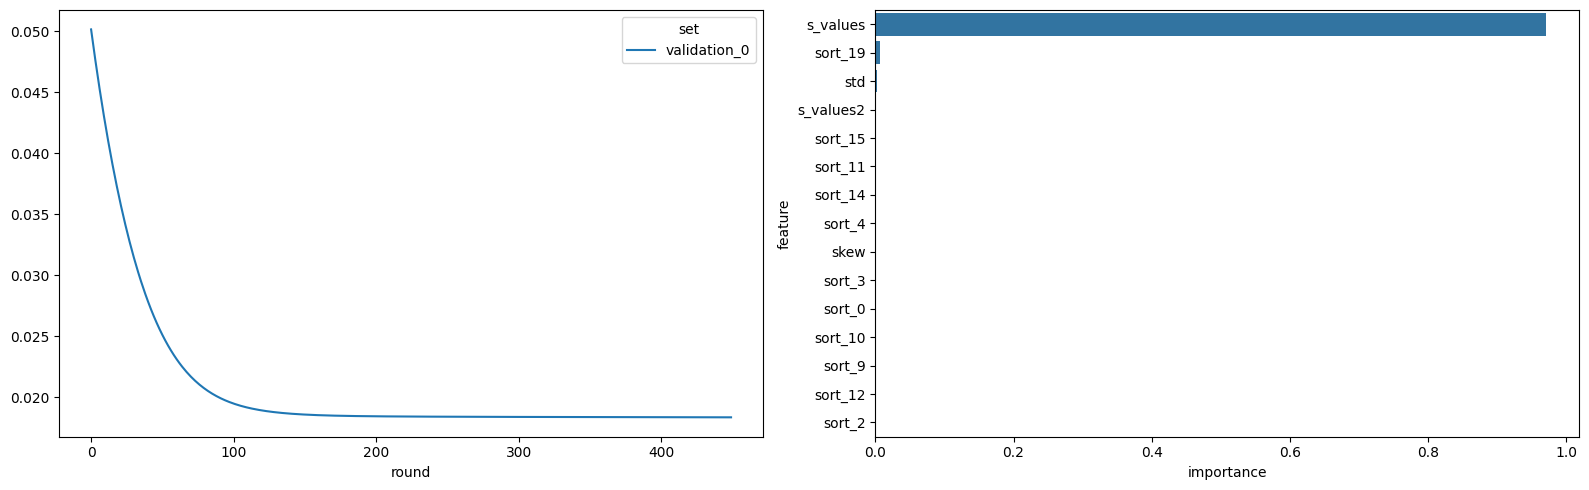

Valid.: 0.86927±0.00025, Train: 0.87042±0.00007


In [37]:
show_gb_cv_result(*stk.get_best_result('xgb2'), metric='rmse')

In [38]:
if not 'xgb2' in stk.get_selected_model():
    m = stk.select_model('xgb2')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

In [39]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86933±0.00026, Train: 0.86933±0.00006


# CatBoost

## CB1

In [40]:
cb_eval = partial(stk.eval_model, model=cb.CatBoostRegressor, result_proc=sgml.cb_learning_result)

In [41]:
m, train_result = cb_eval('cb1', model_params={
        'n_estimators': 800
    },
    X=['MonsoonIntensity'] + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, 'RMSE')

In [42]:
m, _ = stk.get_best_result('cb1')
print_metrics(m['valid_metrics'], m['train_metrics'])

Valid.: 0.86913±0.00027, Train: 0.87095±0.00007


In [43]:
if not 'cb1' in stk.get_selected_model():
    m = stk.select_model('cb1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

In [44]:
def lr_learning_result(m, train_result):
    return (
        pd.Series(
            m.coef_, index=train_result['variables']
        ).sort_values(),
        train_result
    )

Valid.: 0.86935±0.00026, Train: 0.86935±0.00007


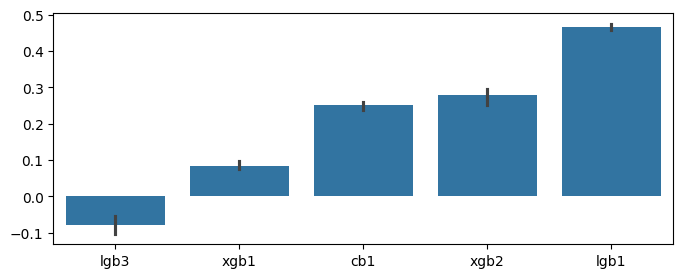

In [45]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

## Submission 3: Ensemble lgb1, lgb3, xgb1, xgb2, cb1

In [46]:
if not os.path.exists(os.path.join(result_path, 'stk_m5.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m5.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m5.csv -m "stk_m5"

Public Score: 0.86927

## CB2

s_values를 범주형으로 하여 모델을 만들어봅니다.

In [47]:
m, train_result = cb_eval('cb2', model_params={
        'n_estimators': 450
    },
    X=['MonsoonIntensity'] + X_sort + ['s_values', 's_values_c', 's_values2'] + X_stat, 
    train_params={
        'fit_params': {'verbose':False, 'cat_features': ['s_values_c']},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, 'RMSE')

In [48]:
stk.get_model_results('cb2').sort_values('valid_metrics', ascending=False).iloc[:3]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
3,CatBoostRegressor,None,{'n_estimators': 400},"MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87063±0.00007,0.86917±0.00025,"{'result_proc': <function cb_learning_result at 0x7f0bbd179d00>, 'train_data_proc': None, 'train..."
4,CatBoostRegressor,None,{'n_estimators': 450},"MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87069±0.00009,0.86917±0.00025,"{'result_proc': <function cb_learning_result at 0x7f0bbd179d00>, 'train_data_proc': None, 'train..."
2,CatBoostRegressor,None,{'n_estimators': 350},"MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87055±0.00009,0.86914±0.00026,"{'result_proc': <function cb_learning_result at 0x7f0bbd179d00>, 'train_data_proc': None, 'train..."


In [49]:
if not 'cb2' in stk.get_selected_model():
    m = stk.select_model('cb2')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

Valid.: 0.86937±0.00026, Train: 0.86937±0.00006


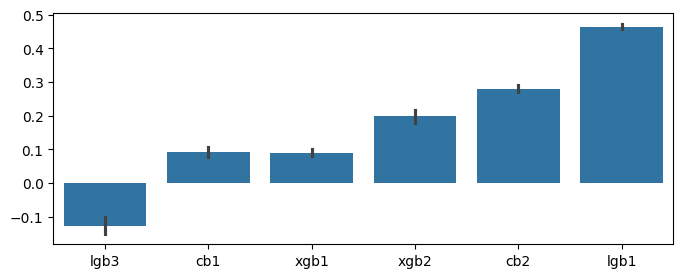

In [50]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'cb2'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

# Neural Networks

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf

## NN1

Neural Network는 데이터 분석 단계에서 다른 GB 모델에 비해 낮은 성능을 보였지만, 다른 양상의 결과를 보이고 있어 포함을 시켜봅니다.

In [52]:
m, train_result = stk.eval_model(
    'nn1', sgnn.NNRegressor, 
    model_params={
        'network_config': [
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True}
        ],
        'batch_size': 1024,
        'shuffle_size': 2048000,
        'verbose': 0,
        'validation_fraction': 0.1,
        'learning_rate': 0.001,
        'reduce_lr_on_plateau': {'factor': 0.1, 'patience': 5},
        'early_stopping': {'patience': 5},
        'epochs': 150
    },
    X=[X_sort[0], X_sort[-2], X_sort[-1]] + ['s_values', 's_values2', 'special1'], 
    preprocessor=ColumnTransformer([
        ('std', StandardScaler(), [X_sort[0], X_sort[-2], X_sort[-1]] + ['s_values', 's_values2']),
        ('pt', 'passthrough', ['special1'])
    ]),
    train_params={
        'fit_params': {'metrics': [tf.keras.metrics.R2Score()]}
    }
)

In [53]:
print_metrics(m['train_metrics'], m['valid_metrics'])

Valid.: 0.86328±0.00089, Train: 0.86263±0.00111


In [54]:
if not 'nn1' in stk.get_selected_model():
    m = stk.select_model('nn1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

Valid.: 0.86936±0.00026, Train: 0.86937±0.00006


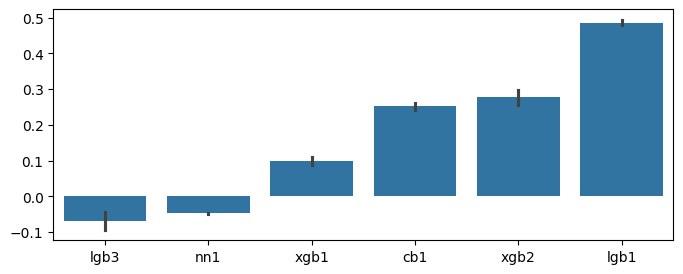

In [55]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

## Submission 4: Ensemble lgb1, lgb3, xgb1, xgb2, cb1, nn1

In [56]:
if not os.path.exists(os.path.join(result_path, 'stk_m6.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m6.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m6.csv -m "stk_m6"

Public Score: 0.86929 

약 0.00002의 성능 향상이 있었습니다.

In [57]:
from IPython.display import Image
img_path = 'img'
def cache_fig(img_name, img_func, nrow, ncol, figsize, redraw=False):
    img_file_name = os.path.join(img_path, img_name + '.png')
    if not os.path.exists(img_file_name) or redraw:
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        if nrow * ncol > 1:
            img_func(axes.ravel())
        else:
            img_func(axes)
        plt.tight_layout()
        plt.savefig(img_file_name)
        plt.show()
    else:
        display(Image(filename=img_file_name))

def diff_graph(axes, s_prd, s_res):
    sns.lineplot(
        pd.concat([(s_prd * 200).astype('int') / 200, stk.df_train['FloodProbability']], axis=1), x=s_prd.name, y='FloodProbability', ax=axes[0]
    )
    sns.lineplot(
        pd.concat([(s_prd * 200).astype('int') / 200, s_res], axis=1), x=s_prd.name, y=s_res.name, ax=axes[1]
    )
    axes[1].axhline(0)
    sns.scatterplot(
        pd.concat([s_prd, s_res], axis=1), x=s_prd.name, y=s_res.name, ax=axes[2], s=10, alpha=0.01
    )

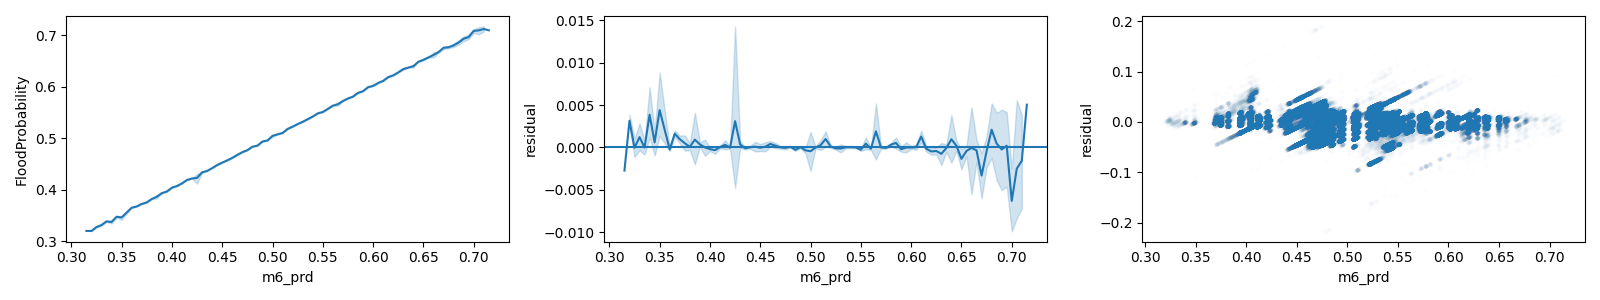

In [58]:
s_res_m6 = (s_prd - stk.df_train['FloodProbability']).rename('residual')
s_prd = s_prd.rename('m6_prd')
cache_fig('m6_diff', 
          partial(diff_graph, s_prd=s_prd, s_res=s_res_m6), 
          nrow=1, ncol=3, figsize=(16, 3))

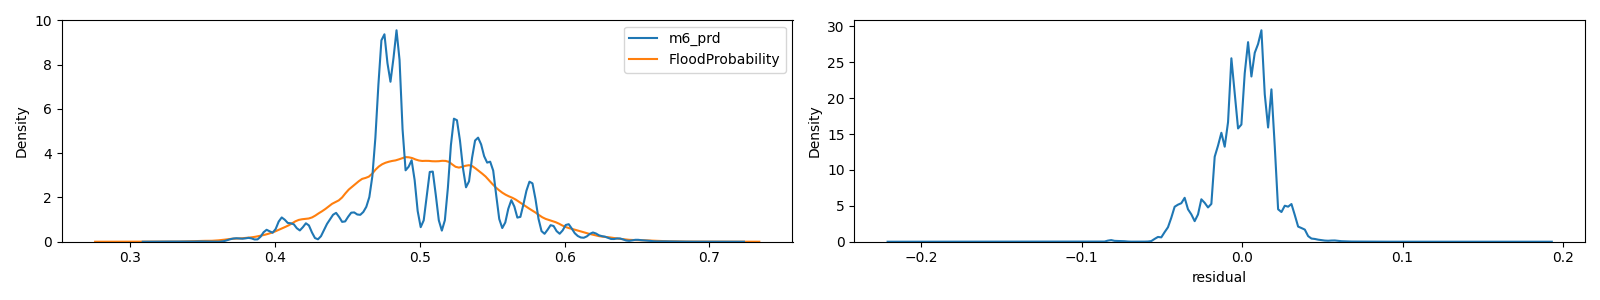

In [59]:
def kde_km_prd_target_residual(axes, s_prd, s_res):
    sns.kdeplot(pd.concat([s_prd, stk.df_train['FloodProbability']], axis=1), ax=axes[0])
    sns.kdeplot(s_res, ax=axes[1])
    
cache_fig(
    'kde_m6_prd_target_residual',
    lambda x: kde_km_prd_target_residual(x, s_prd, s_res_m6), nrow=1, ncol=2, figsize=(16, 3)
)

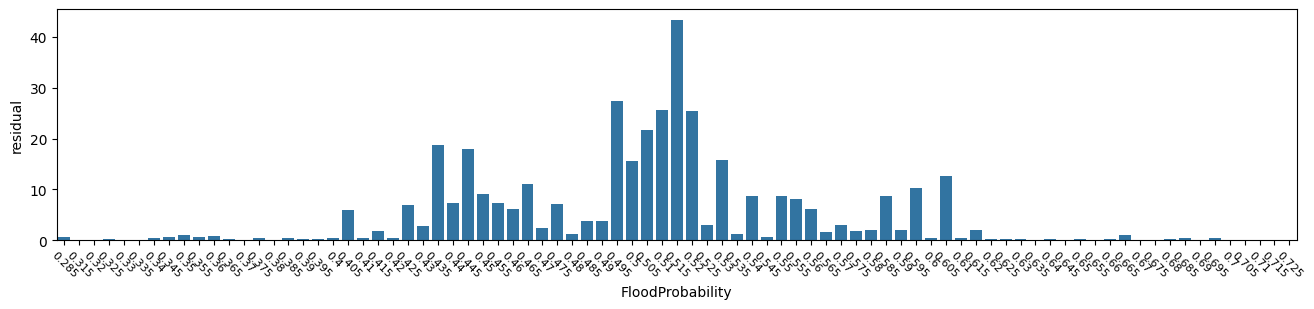

In [60]:
plt.figure(figsize=(16, 3))
sns.barplot((s_res_m6 ** 2).groupby(stk.df_train['FloodProbability']).sum())
plt.xticks(rotation=-45, fontsize=8)
plt.show()

## NN2

s_values_c를 embedding을 사용하여 신경망을 구성한 모델을 만듭니다.

In [104]:
from sklearn.preprocessing import OrdinalEncoder
X_nn_std = [X_sort[0], X_sort[1], X_sort[-2], X_sort[-1], 's_values', 's_values2']
m, train_result = stk.eval_model(
    'nn2', sgnn.NNRegressor, 
    model_params={
        'network_config': [
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True}
        ],
        'embedding': [(1, stk.df_train['s_values_c'].nunique(), 32, 0, 0),],
        'batch_size': 1024,
        'shuffle_size': 2048000,
        'verbose': 0,
        'validation_fraction': 0.1,
        'learning_rate': 0.001,
        'reduce_lr_on_plateau': {'factor': 0.1, 'patience': 5},
        'early_stopping': {'patience': 5},
        'epochs': 150
    },
    X= X_nn_std + ['s_values_c', 'special1'], 
    preprocessor=ColumnTransformer([
        ('std', StandardScaler(), X_nn_std),
        ('pt', 'passthrough', ['special1']),
        ('ord', OrdinalEncoder(), ['s_values_c'])
    ]),
    train_params={
        'fit_params': {'metrics': [tf.keras.metrics.R2Score()]}
    }
)

In [105]:
print_metrics(m['train_metrics'], m['valid_metrics'])

Valid.: 0.86655±0.00082, Train: 0.86545±0.00098


In [106]:
stk.get_model_results('nn2').sort_values('valid_metrics', ascending=False).head(2)

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
4,NNRegressor,"ColumnTransformer(transformers=[('std', StandardScaler(),\n ['so...","{'network_config': [{'unit': 128, 'activation': 'relu', 'batch_norm': True}, {'unit': 128, 'acti...","sort_0,sort_1,sort_18,sort_19,s_values,s_values2,s_values_c,special1",0.86659±0.00075,0.86556±0.00097,"{'result_proc': None, 'train_data_proc': None, 'train_params': {'fit_params': {'metrics': [<R2Sc..."
5,NNRegressor,"ColumnTransformer(transformers=[('std', StandardScaler(),\n ['so...","{'network_config': [{'unit': 128, 'activation': 'relu', 'batch_norm': True}, {'unit': 128, 'acti...","sort_0,sort_1,sort_18,sort_19,s_values,s_values2,s_values_c,special1",0.86655±0.00082,0.86545±0.00098,"{'result_proc': None, 'train_data_proc': None, 'train_params': {'fit_params': {'metrics': [<R2Sc..."


In [107]:
if not 'nn2' in stk.get_selected_model():
    m = stk.select_model('nn2')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

Valid.: 0.86941±0.00026, Train: 0.86941±0.00007


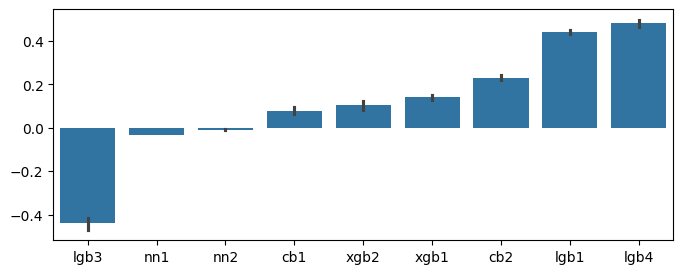

In [108]:
train_metrics, eval_metrics, s_prd_m8, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1', 'nn2'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

### Submission 8: Stacking 10 -  Ensemble lgb1, lgb3, lgb4, xgb1, xgb2, cb1, cb2, nn1, nn2

In [110]:
if not os.path.exists(os.path.join(result_path, 'stk_m10.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1', 'nn2'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m10.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m10.csv -m "stk_m10"

/home/sun9sun9/python312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [11:52:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.88MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

**Public Score: 0.86932**

## 예측의 분포와 타겟의 분포가 차이가 나는 지점 분석

### target between (0.4, 0.5)

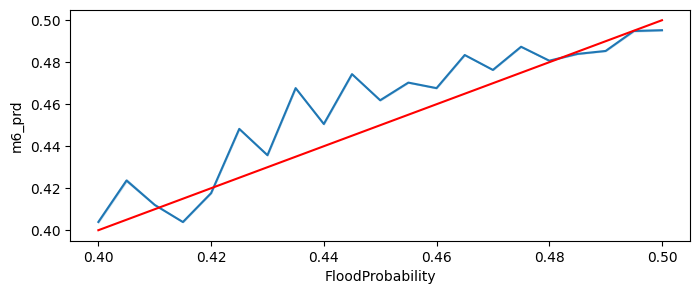

In [61]:
plt.figure(figsize=(8, 3))
s_bidx = stk.df_train['FloodProbability'].between(0.4, 0.5)
sns.lineplot(x=stk.df_train.loc[s_bidx, 'FloodProbability'], y=s_prd.loc[s_bidx])
plt.plot([0.4, 0.5], [0.4, 0.5], color='red')
plt.show()

FloodProbability가 0.425 0.475 의 예측값은 실제값보다 높습니다. 이 구간만을 놓고 모델을 만들어봅니다.

In [62]:
s_bidx = stk.df_train['FloodProbability'].between(0.425, 0.475)
df_tmp = stk.df_train.loc[s_bidx]
((df_tmp['FloodProbability'] - s_prd.loc[s_bidx]) ** 2).sum()

96.87694923786506

In [63]:
((stk.df_train['FloodProbability'] - s_prd) ** 2).sum()

380.25314287454336

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
s_tmp_prd = cross_val_predict(LinearRegression(fit_intercept=False), df_tmp[['s_values']], df_tmp['FloodProbability'], cv=stk.sp)

In [65]:
((df_tmp['FloodProbability'] - s_tmp_prd) ** 2).sum()

28.582792250525078

In [66]:
reg_lr = LinearRegression(fit_intercept=False).fit(df_tmp[['s_values']], df_tmp['FloodProbability'])
reg_lr.coef_

array([0.00489108])

In [67]:
reg_lr = LinearRegression(fit_intercept=False).fit(stk.df_train[['s_values']], stk.df_train['FloodProbability'])
reg_lr.coef_

array([0.00511047])

s_values에 대한 계수가 차이가 납니다. 

데이터 분석에서 s_values FloodProbability

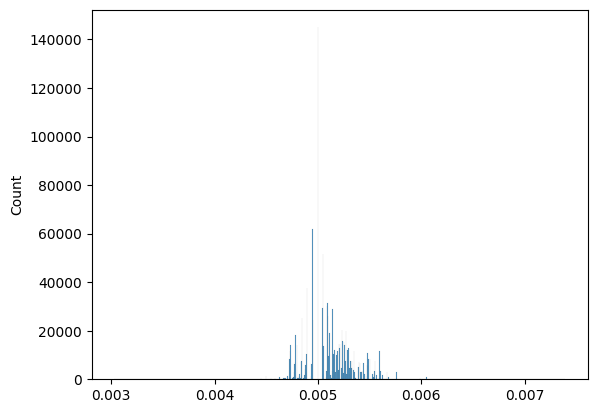

In [68]:
sns.histplot(
    stk.df_train['FloodProbability'] / stk.df_train['s_values']
)
plt.show()

<Axes: xlabel='s_values', ylabel='None'>

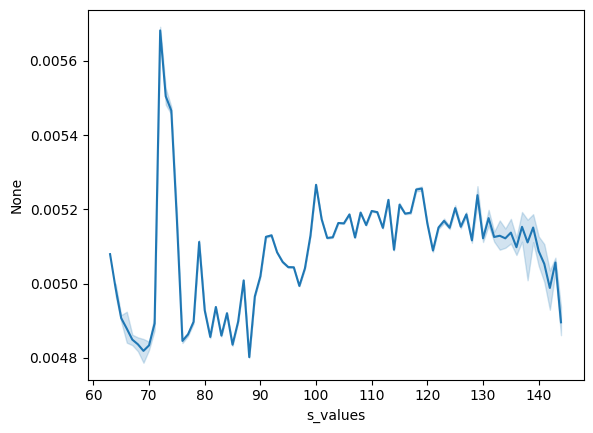

In [69]:
sns.lineplot(
    x=stk.df_train['s_values'], y=stk.df_train['FloodProbability'] / stk.df_train['s_values']
)

FloodProbaility를 맞추는 것보다는 s_values와 FloodPrbability의 비율을 맞추는 것이 더 쉬울 수 있지 않을까 합니다. 

이를 Data 데이터 분석 단계에서 살펴봅니다.

# Ratio Target Model

분석 단계에서는 원래 target으로 했을 때와 비슷한 성능을 보였습니다. 

분포상으는 target으로 했을 때와 육안으로느 크게 다르지는 않았지만, 보완 역활을 해줄지는 확인해볼만합니다.


### LGB_r1

In [70]:
m, train_result = lgb_eval(
    'lgb_r1', model_params={'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_samples': 32, 'subsample_freq': 1, 'subsample': 0.75}, 
    X= X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    target_func=ratio_func, target_invfunc=ratio_invfunc,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

In [71]:
show_gb_cv_result(m, train_result)

In [72]:
stk.get_model_results('lgb_r1').sort_values('valid_metrics', ascending=False).iloc[:3]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
7,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples...","sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,sort_11,sort_12,so...",0.87058±0.00007,0.86910±0.00026,"{'result_proc': <function lgb_learning_result at 0x7f71c9a65bc0>, 'train_data_proc': None, 'trai..."
10,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples...","sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,sort_11,sort_12,so...",0.87058±0.00007,0.86910±0.00026,"{'result_proc': <function lgb_learning_result at 0x7f71c9a65bc0>, 'train_data_proc': None, 'trai..."
12,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples...","sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,sort_11,sort_12,so...",0.87058±0.00007,0.86910±0.00026,"{'result_proc': <function lgb_learning_result at 0x7f71c9a65bc0>, 'train_data_proc': None, 'trai..."


In [73]:
m, train_result = lgb_eval(
    'lgb_r1', model_params={'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples': 32, 'subsample_freq': 1, 'subsample': 0.75}, 
    X= X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    target_func=ratio_func, target_invfunc=ratio_invfunc,
    train_params={
        'fit_params': {'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [74]:
if not 'lgb_r1' in stk.get_selected_model():
    m = stk.select_model('lgb_r1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

Valid.: 0.86937±0.00026, Train: 0.86937±0.00006


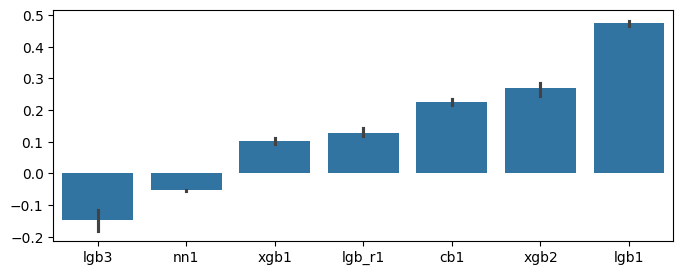

In [75]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1', 'lgb_r1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

In [76]:
if not os.path.exists(os.path.join(result_path, 'stk_m7.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1', 'lgb_r1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m7.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m7.csv -m "stk_m7"

Public Score: 0.86926 성능이 떨어졌습니다.

## Stackiing + lgb4

Valid.: 0.86940±0.00026, Train: 0.86940±0.00007


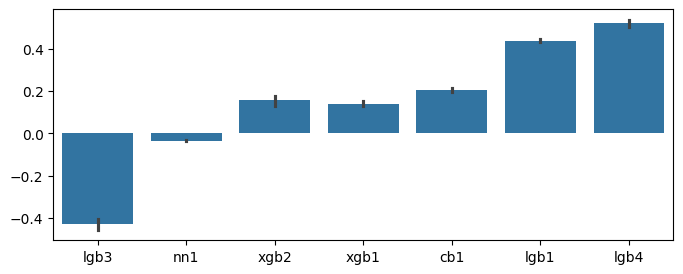

In [77]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'nn1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

## Submission 5: Stacking 7 - Ensemble lgb1, lgb3, lgb4, xgb1, xgb2, cb1, nn1

In [78]:
if not os.path.exists(os.path.join(result_path, 'stk_m7.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'nn1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m7.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m7.csv -m "stk_m7"

Public Score: 0.86931

## Stacking + cb2

Valid.: 0.86941±0.00026, Train: 0.86941±0.00007


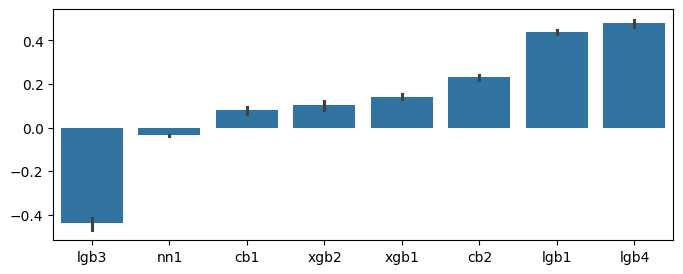

In [79]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

## Submission 6: Stacking 8 - Ensemble lgb1, lgb3, lgb4, xgb1, xgb2, cb1, cb2, nn1

In [80]:
if not os.path.exists(os.path.join(result_path, 'stk_m8.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m8.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m8.csv -m "stk_m8"

Public Score: 0.86932

# Groupby s_values_c

s_values_c에 따라 데이터의 양상이 다르다는 것을 special1 속성을 조사할 때 관찰했습니다. 

이러한 성질을 반영하여 s_values_c 별로 LightGBM 모델을 만들어 예측을 해봅니다.

In [92]:
from sklearn.model_selection import train_test_split
def predict(m, df, X):
    return pd.Series(m.predict(df[X]), index=df.index)

def eval_metric(df, y_prd):
    return r2_score(df['FloodProbability'], y_prd)

def valid_splitter(df):
    return train_test_split(df, train_size=0.8, random_state=123)

result_path = 'result'
def cache_result(result_name, result_func, rerun=False):
    result_file_name = os.path.join(result_path, result_name + '.pkl')
    if not os.path.exists(result_file_name) or rerun:
        result = result_func()
        if result is None:
            return
        with open(result_file_name, 'wb') as f:
            pkl.dump(result, f)
    else:
        with open(result_file_name, 'rb') as f:
            result = pkl.load(f)
    return result

def cv_predict(df):
    cv_result = sgml.cv_model(
        KFold(10, random_state=123, shuffle=True), 
        lgb.LGBMRegressor, {'learning_rate': 0.03, 'n_estimators': 1000, 'verbose': -1, 'num_leaves': 7},
        df, X_sort + ['s_values', 's_values2'] + X_stat, 'FloodProbability', 
        predict, eval_metric,
        result_proc=sgml.lgb_learning_result,
        train_params={
            'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)]},
            'valid_splitter': valid_splitter,
            'valid_config_proc': sgml.gb_valid_config
        }
    )
    cv_prd = cv_result[2]
    m_est = int(np.mean([len(i[0]) for i in cv_result[3]]) + 0.5)
    return (cv_prd, m_est)

s_bygrp = cache_result(
    's_bygrp', 
    lambda : stk.df_train.groupby('s_values_c', group_keys=False).apply(lambda x: cv_predict(x), include_groups=False)
)
r2_score(stk.df_train['FloodProbability'], pd.concat([i[0] for i in s_bygrp], axis=0).sort_index())

0.8692037987965864

In [93]:
s_est = s_bygrp.apply(lambda x: x[1])

In [94]:
X_sel = X_sort + ['s_values', 's_values2'] + X_stat
s_bygrp2 = cache_result(
    's_bygrp2',
    lambda : stk.df_train.groupby('s_values_c', group_keys=False).apply(
        lambda x: sgml.cv_model(
            KFold(10, random_state=123, shuffle=True), 
            lgb.LGBMRegressor, {'learning_rate': 0.03, 'n_estimators': s_est[x.name], 'verbose': -1, 'num_leaves': 7},
            x, X_sort + ['s_values', 's_values2'] + X_stat, 'FloodProbability', 
            predict, eval_metric
        )[2], include_groups=False
    ).sort_index()
)
r2_score(stk.df_train['FloodProbability'], s_bygrp2.values)

0.8692750512208872

In [112]:
train_metrics, eval_metrics, s_prd_m7, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1', 'nn2'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86941±0.00026, Train: 0.86941±0.00007


In [114]:
ls = np.linspace(0, 1, 101)
r2_ls = cache_result(
    'r2_ls', 
    lambda : [r2_score(stk.df_train['FloodProbability'],  s_prd_m7 * i + s_bygrp2 * (1 - i)) for i in ls]
)
ls[np.argmax(r2_ls)], np.max(r2_ls)

(0.7000000000000001, 0.8694373519439449)

0.00003의 성능 개선을 보였습니다.

In [111]:
s_lgb_prd_test = cache_result(
    's_lgb_prd_test',
    lambda : stk.df_train.groupby('s_values_c', group_keys=False).apply(
        lambda x: pd.Series(
            lgb.LGBMRegressor(learning_rate=0.03, n_estimators=int(s_est[x.name] * 1.2), verbose=-1, num_leaves=7).fit(x[X_sel], x['FloodProbability'])\
                .predict(df_test.loc[df_test['s_values_c'] == x.name, X_sel]), index=df_test.loc[df_test['s_values_c'] == x.name].index
        ), include_groups=False
    ), rerun=True
).sort_index()

## Submission 7: Stacking 9 - Ensemble lgb1, lgb3, lgb4, xgb1, xgb2, cb1, cb2, nn1, grp

In [96]:
if not os.path.exists(os.path.join(result_path, 'stk_m9.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1'])
    pd.Series(stk.predict(df_test) * 0.71 + s_lgb_prd_test * 0.29, index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m9.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m9.csv -m "stk_m9"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 5.02MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score: 0.86931

## Submission 11: Stacking 11 - Ensemble lgb1, lgb3, lgb4, xgb1, xgb2, cb1, cb2, nn1, grp

In [115]:
if not os.path.exists(os.path.join(result_path, 'stk_m11.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'lgb4', 'xgb1', 'xgb2', 'cb1', 'cb2', 'nn1', 'nn2'])
    pd.Series(stk.predict(df_test) * 0.70 + s_lgb_prd_test * 0.3, index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m11.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m11.csv -m "stk_m11"

100%|██████████████████████████████████████| 19.3M/19.3M [00:03<00:00, 6.10MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score: 0.86932

# Ensembling with others

## e1

e1: stk_m6

e2: https://www.kaggle.com/code/aspillai/flood-prediction-regression-lightgbm-0-86931


In [68]:
if not os.path.exists('data/e2.csv'):
    !kaggle kernels output ravaghi/s04e05-flood-prediction-ensemble 
    !rm s04e05-flood-prediction-ensemble.log
    !mv ensemble.csv data/e2.csv

Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/catboost_training.json
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/learn/events.out.tfevents
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/learn_error.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/time_left.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/ensemble.csv
Kernel log downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/s04e05-flood-prediction-ensemble.log 
rm: cannot remove 'flood-prediction-*.log': No such file or directory


In [70]:
if not os.path.exists(os.path.join(result_path, 'e1.csv')):
    pd.concat([
        pd.read_csv('result/stk_m6.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'})
    ], axis=1).dot([0.7, 0.3]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e1.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e1.csv -m "e1"

## e2

e3: https://www.kaggle.com/code/ravaghi/s04e05-flood-prediction-ensemble/notebook

In [71]:
if not os.path.exists('data/e3.csv'):
    !kaggle kernels output aspillai/flood-prediction-regression-lightgbm-0-86925
    !rm flood-prediction-regression-lightgbm-0-86925.log 
    !mv submission.csv data/e3.csv

In [72]:
if not os.path.exists(os.path.join(result_path, 'e2.csv')):
    pd.concat([
        pd.read_csv('result/stk_m6.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
    ], axis=1).dot([0.65, 0.25, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e2.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e2.csv -m "e2"

## e3

e4: https://www.kaggle.com/code/ambrosm/pss4e5-eda-which-makes-sense/

In [75]:
if not os.path.exists('data/e4.csv'):
    !kaggle kernels output ambrosm/pss4e5-eda-which-makes-sense
    !rm pss4e5-eda-which-makes-sense.log 
    !mv submission.csv data/e4.csv

In [78]:
if not os.path.exists(os.path.join(result_path, 'e3.csv')):
    pd.concat([
        pd.read_csv('result/stk_m6.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
    ], axis=1).dot([0.60, 0.15, 0.15, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e3.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e3.csv -m "e3"

100%|██████████████████████████████████████| 19.3M/19.3M [00:03<00:00, 5.74MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score: 0.86933

## e4

stk_m7 모델의 결과를 반영합니다.

In [111]:
if not os.path.exists(os.path.join(result_path, 'e4.csv')):
    pd.concat([
        pd.read_csv('result/stk_m7.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
    ], axis=1).dot([0.60, 0.15, 0.15, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e4.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e4.csv -m "e4"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.74MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score: 0.86934

## e5

stk_m8 모델의 결과를 반영합니다.

In [61]:
if not os.path.exists(os.path.join(result_path, 'e5.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
    ], axis=1).dot([0.70, 0.1, 0.1, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e5.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e5.csv -m "e5"

100%|██████████████████████████████████████| 19.3M/19.3M [00:03<00:00, 5.76MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [62]:
if not os.path.exists(os.path.join(result_path, 'e5_2.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
    ], axis=1).dot([0.60, 0.15, 0.15, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e5_2.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e5_2.csv -m "e5"

100%|██████████████████████████████████████| 19.3M/19.3M [00:03<00:00, 5.80MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score: 0.86935

## e6

e5: https://www.kaggle.com/code/trupologhelper/ps4e5-openfe-blending-explain

In [66]:
if not os.path.exists('data/e5.csv'):
    !kaggle kernels output trupologhelper/ps4e5-openfe-blending-explain
    !mv submission.csv data/e5.csv
    !rm ps4e5-openfe-blending-explain.log 

In [67]:
if not os.path.exists(os.path.join(result_path, 'e6.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
    ], axis=1).dot([0.50, 0.15, 0.15, 0.1, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e6.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e6.csv -m "e6"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.84MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [97]:
if not os.path.exists(os.path.join(result_path, 'e6_2.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e5.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
    ], axis=1).dot([0.50, 0.1, 0.1, 0.1, 0.2]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e6_2.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e6_2.csv -m "e6_2"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 5.00MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score 0.86937

## e7

e6: https://www.kaggle.com/code/meloncc/autogluon-hpo-better

In [100]:
if not os.path.exists('data/e6.csv'):
    !kaggle kernels output meloncc/autogluon-hpo-better
    !mv submission.csv data/e6.csv
    !rm autogluon-hpo-better.log

Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/submission.csv
Kernel log downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/autogluon-hpo-better.log 


In [101]:
if not os.path.exists(os.path.join(result_path, 'e7.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e2.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e5.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
        pd.read_csv('data/e6.csv', index_col='id').rename(columns={'FloodProbability': 'e6'}),
    ], axis=1).dot([0.40, 0.1, 0.1, 0.05, 0.2, 0.15]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e7.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e7.csv -m "e7"

100%|██████████████████████████████████████| 19.3M/19.3M [00:05<00:00, 3.42MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score 0.86938

## e8

e2 대신에 이 사람이 나중에 만든 앙상블 모델을 추가합니다.

e7: https://www.kaggle.com/code/aspillai/flood-prediction-regression-lgb-xgb-cat

e8: https://www.kaggle.com/code/satyaprakashshukl/flood-analysis-h20

In [102]:
if not os.path.exists('data/e7.csv'):
    !kaggle kernels output aspillai/flood-prediction-regression-lgb-xgb-cat
    !rm -rf catboost_info
    !mv submission.csv data/e7.csv
    !rm flood-prediction-regression-lgb-xgb-cat.log 

Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/catboost_training.json
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/learn/events.out.tfevents
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/learn_error.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/test/events.out.tfevents
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/test1/events.out.tfevents
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/test_error.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/time_left.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/submission.csv
Kernel log downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/flood-prediction-regression-lgb-xgb-cat.log 


In [106]:
if not os.path.exists('data/e8.csv'):
    !kaggle kernels output satyaprakashshukl/flood-analysis-h20
    !mv submission.csv data/e8.csv
    !rm flood-analysis-h20.log 

In [108]:
if not os.path.exists(os.path.join(result_path, 'e8.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e7.csv', index_col='id').rename(columns={'FloodProbability': 'e7'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e5.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
        pd.read_csv('data/e6.csv', index_col='id').rename(columns={'FloodProbability': 'e6'}),
        pd.read_csv('data/e8.csv', index_col='id').rename(columns={'FloodProbability': 'e8'}),
    ], axis=1).dot([0.35, 0.1, 0.1, 0.05, 0.2, 0.1, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e8.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e8.csv -m "e8"

100%|██████████████████████████████████████| 19.3M/19.3M [00:03<00:00, 6.28MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score 0.86939

## e9

e2 대신에 이 사람이 나중에 만든 앙상블 모델을 추가합니다.

e9: https://www.kaggle.com/code/omidbaghchehsaraei/ps4e5-floodprediction-xgboost-publicscore-0-86921

In [109]:
if not os.path.exists('data/e9.csv'):
    !kaggle kernels output omidbaghchehsaraei/ps4e5-floodprediction-xgboost-publicscore-0-86921
    !mv submission.csv data/e9.csv
    !rm ps4e5-floodprediction-xgboost-publicscore-0-86921.log

Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/submission.csv
Kernel log downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/ps4e5-floodprediction-xgboost-publicscore-0-86921.log 


In [112]:
if not os.path.exists(os.path.join(result_path, 'e9.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e7.csv', index_col='id').rename(columns={'FloodProbability': 'e7'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e5.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
        pd.read_csv('data/e6.csv', index_col='id').rename(columns={'FloodProbability': 'e6'}),
        pd.read_csv('data/e8.csv', index_col='id').rename(columns={'FloodProbability': 'e8'}),
        pd.read_csv('data/e9.csv', index_col='id').rename(columns={'FloodProbability': 'e9'}),
    ], axis=1).dot([0.35, 0.1, 0.05, 0.05, 0.2, 0.1, 0.1, 0.05]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e9.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e9.csv -m "e9"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.88MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

## e10

e10: https://www.kaggle.com/code/michaelxyjonathan/s04e05-flood-prediction-r2-score-0-86933

In [116]:
if not os.path.exists('data/e10.csv'):
    !kaggle kernels output michaelxyjonathan/s04e05-flood-prediction-r2-score-0-86933
    !mv submission.csv data/e10.csv
    !rm s04e05-flood-prediction-r2-score-0-86933.log

Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/catboost_training.json
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/learn/events.out.tfevents
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/learn_error.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/test/events.out.tfevents
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/test_error.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/catboost_info/time_left.tsv
Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/submission.csv
Kernel log downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/s04e05-flood-prediction-r2-score-0-86933.log 
rm: cannot remove 'ps4e5-floodprediction-xgboost-publicscore-0-86921.log': No such file or directory


In [123]:
if not os.path.exists(os.path.join(result_path, 'e10.csv')):
    pd.concat([
        pd.read_csv('result/stk_m11.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e7.csv', index_col='id').rename(columns={'FloodProbability': 'e7'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e5.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
        pd.read_csv('data/e6.csv', index_col='id').rename(columns={'FloodProbability': 'e6'}),
        pd.read_csv('data/e8.csv', index_col='id').rename(columns={'FloodProbability': 'e8'}),
        pd.read_csv('data/e9.csv', index_col='id').rename(columns={'FloodProbability': 'e9'}),
        pd.read_csv('data/e9.csv', index_col='id').rename(columns={'FloodProbability': 'e10'}),
    ], axis=1).dot([0.4, 0.05, 0.05, 0.05, 0.15, 0.1, 0.1, 0.05, 0.05]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e10.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e10.csv -m "e10"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.92MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

**Public Score: 0.86938**

## e12

In [129]:
if not os.path.exists(os.path.join(result_path, 'e11.csv')):
    pd.concat([
        pd.read_csv('result/stk_m8.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/e7.csv', index_col='id').rename(columns={'FloodProbability': 'e7'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
        pd.read_csv('data/e4.csv', index_col='id').rename(columns={'FloodProbability': 'e4'}),
        pd.read_csv('data/e5.csv', index_col='id').rename(columns={'FloodProbability': 'e5'}),
        pd.read_csv('data/e6.csv', index_col='id').rename(columns={'FloodProbability': 'e6'}),
        pd.read_csv('data/e8.csv', index_col='id').rename(columns={'FloodProbability': 'e8'}),
        pd.read_csv('data/e9.csv', index_col='id').rename(columns={'FloodProbability': 'e9'}),
        pd.read_csv('data/e9.csv', index_col='id').rename(columns={'FloodProbability': 'e10'}),
    ], axis=1).dot([0.35, 0.05, 0.05, 0.05, 0.15, 0.1, 0.1, 0.05, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e11.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e9.csv -m "e11"

100%|██████████████████████████████████████| 19.3M/19.3M [00:03<00:00, 5.63MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [128]:
np.sum([0.35, 0.05, 0.05, 0.05, 0.15, 0.1, 0.1, 0.05, 0.1])

1.0